In [19]:
import numpy as np
import pandas as pd
from chess import Board
from stockfish import Stockfish
from tqdm import tqdm

In [2]:
games_df = pd.read_csv("data/games.csv")
games_df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


<AxesSubplot: >

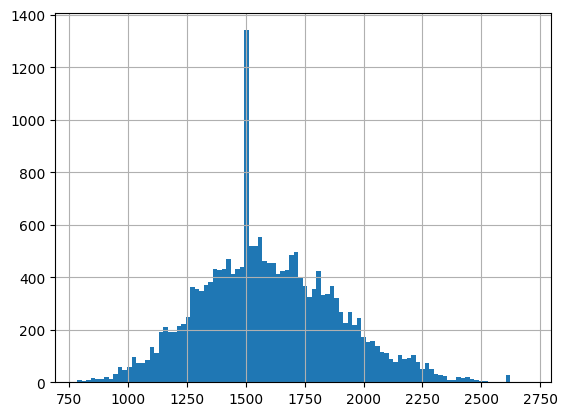

In [3]:
games_df.white_rating.hist(bins=100)

<AxesSubplot: >

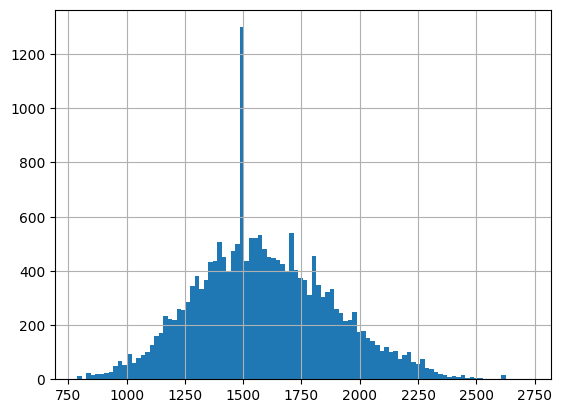

In [4]:
games_df.black_rating.hist(bins=100)

In [5]:
all_positions = []
for _, game in games_df.iterrows():
    moves = game["moves"].split(' ')
    board = Board()
    for move in moves:
        board.push_san(move)
        all_positions.append(board.fen())
len(all_positions)

1212827

Remove duplicate states

In [7]:
unique_positions = list(set(all_positions))
len(unique_positions)

1024317

Let's create our own DataFrame with only necessary data

In [10]:
df = pd.DataFrame({"positions": unique_positions})
df.head()

,positions
0,4r3/2pk3p/p2bnpnP/1p2p3/2B1P3/2P1BP2/PPKN1P2/6...
1,r1bqk1nr/ppp2ppp/2n5/2N5/2pp4/1P6/P3PPPP/R2QKB...
2,8/1kp2N2/pbp2pp1/4r3/4P1P1/2PR1P1P/PP4K1/8 b -...
3,rnbq2nr/pp1pk3/3p1p1p/3Np1pQ/3PP3/7P/PP3PP1/R1...
4,5N1k/7P/2p1K3/1p1pP3/3P4/8/2n5/8 b - - 3 80


Let's extract which side is to move from the board representation

In [13]:
def extract_side(row):
    state = row["positions"]
    color = state.split(" ")[1]
    return 1 if color == "b" else 0

df["to_move"] = df.apply(extract_side, axis=1)
df.head()

,positions,to_move
0,4r3/2pk3p/p2bnpnP/1p2p3/2B1P3/2P1BP2/PPKN1P2/6...,0
1,r1bqk1nr/ppp2ppp/2n5/2N5/2pp4/1P6/P3PPPP/R2QKB...,0
2,8/1kp2N2/pbp2pp1/4r3/4P1P1/2PR1P1P/PP4K1/8 b -...,1
3,rnbq2nr/pp1pk3/3p1p1p/3Np1pQ/3PP3/7P/PP3PP1/R1...,1
4,5N1k/7P/2p1K3/1p1pP3/3P4/8/2n5/8 b - - 3 80,1


Let's load the stockfish engine

In [14]:
stockfish_engine = Stockfish('C:/Users/Maciej/PycharmProjects/reinforcement_learning_chess/stockfish_15.1_win_x64_avx2/stockfish_15.1_win_x64_avx2/stockfish-windows-2022-x86-64-avx2.exe', depth=4)

Let's evaluate the board states

In [21]:
evaluations = []
for idx, row in tqdm(df.iterrows()):
    stockfish_engine.set_fen_position(row["positions"])
    evaluations.append(stockfish_engine.get_evaluation())

1024317it [39:39, 430.47it/s]


Let's add the data to dataframe

In [23]:
df["centipawns"] = None
df["mate"] = None
for idx, evaluation in enumerate(evaluations):
    if evaluation["type"] == "mate":
        df.at[idx, "mate"] = 1
    else:
        df.at[idx, "centipawns"] = evaluation["value"]

Let's plot centipawns so we can figure out what value to user for mate

<AxesSubplot: >

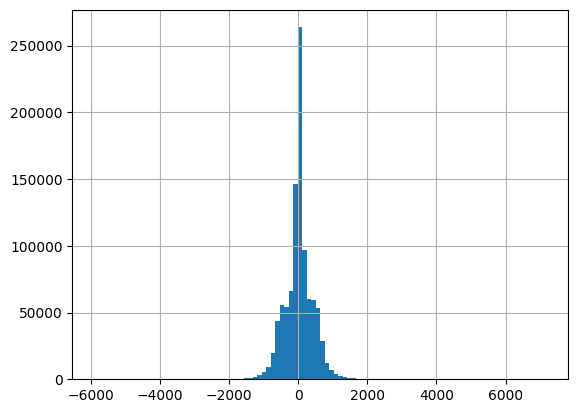

In [25]:
df["centipawns"].hist(bins=100)

In [26]:
df["centipawns"].min(), df["centipawns"].max()

(-5893, 7166)

As 100 centipawns mean that we have an advantage of 1 pawn I pick the value for mate to be 10000 (althoughit might be changed later) Let's calculate the final score

In [30]:
def calculate_score(row):
    return 10_000 if row["mate"] is not None else row["centipawns"]
df["final_score"] = df.apply(calculate_score, axis=1)

In [31]:
df.head()

,positions,to_move,centipawns,mate,final_score
0,4r3/2pk3p/p2bnpnP/1p2p3/2B1P3/2P1BP2/PPKN1P2/6...,0,478,None,478
1,r1bqk1nr/ppp2ppp/2n5/2N5/2pp4/1P6/P3PPPP/R2QKB...,0,-180,None,-180
2,8/1kp2N2/pbp2pp1/4r3/4P1P1/2PR1P1P/PP4K1/8 b -...,1,339,None,339
3,rnbq2nr/pp1pk3/3p1p1p/3Np1pQ/3PP3/7P/PP3PP1/R1...,1,635,None,635
4,5N1k/7P/2p1K3/1p1pP3/3P4/8/2n5/8 b - - 3 80,1,66,None,66


In [32]:
df.to_csv("data_backup.csv", index=False)

## Creating data and labels in tensor format
### Input format
The idea behind the input format is to represent each board as a 8x8x12 tensor (8x8 as it is a board size and 12 as we have 6 type od pieces for each player)
so the idea is that FEN board representation stores information whose move is now.
In our game simulation the course of a turn will look like this. We get all possible future states of the boards and evaluate their value, the better the position the higher the score. But as we generate the possible boards the color of player to move changes. So if the to move color is black that means that we currently evaluate the position for white pieces and vice versa. We want the neural network to kind of "look" from the perspective of the player that picks the best possible state that his opponent need to face. In order to obtain that we will always place the figures of the player that is NOT to move on the upper 6 2d arrays part of the tensor and the opponents pieces on the bottom bart of tensor. What we will also do in case of black player is that we will mirror his pieces in one axis so that it resembles positions white pieces when white player is playing.

### Labels format
As we are switching the sides of the chess piecs to simulate viewing the board we also need to switch the input accordingly. So the metric that we currently use is centipawns, it says how good the white player's position is. Positive value indicates that the position is advantageous for white and negative value means that black is in favor. As we know from the input section when the to move value is indicating that white is to move that means we are currently evaluating white's positions and vice versa. So when to move is black (so we are evaluating white's move) we do not reverse the centipawns as they are evaluating white positions, but when white is to move we need to reverse the centipaws (multiply by -1)

In [43]:
def board_to_tensor(board_instance):
    tensor = np.zeros((12, 8, 8))
    to_move = board_instance.turn # true -> white, false -> black
    for i in range(8): # rows
        for j in range(8): # columns
            piece = board_instance.piece_at(i * 8 + j)
            if piece is not None:
                if to_move: # white -> we do not invert anything
                    if piece.color:
                        tensor[piece.piece_type - 1][i][j] = 1
                    else:
                        tensor[piece.piece_type + 5][i][j] = 1
                else:  # black -> we do not invert anything
                    if not piece.color: # upside down
                        tensor[piece.piece_type - 1][7 - i][j] = 1
                    else:
                        tensor[piece.piece_type + 5][7 - i][j] = 1
    return tensor

In [44]:
def create_input_and_output(row):
    chess_board = Board()
    chess_board.set_fen(row["positions"])
    to_move = chess_board.turn # true -> white, false -> black
    input_repr = board_to_tensor(chess_board)
    centipawn_score = row["final_score"]
    label = centipawn_score if to_move else centipawn_score * (-1)
    return [input_repr, label]

In [49]:
train_data = df.apply(create_input_and_output, axis=1, result_type='expand')

In [55]:
inputs, labels = np.array(train_data[0].to_list()), np.array(train_data[1].to_list())

In [63]:
inputs.tofile("inputs_transformed.npy")
labels.astype(np.float64).tofile("labels.npy")